In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [14]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images('./dataset'))
data = []
labels = []

[INFO] loading images...


In [15]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [16]:
imagePaths[0]

'./dataset/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg'

In [18]:
imagePaths[0].split(os.path.sep)[-2]

'covid'

In [21]:
for im in imagePaths:
    label = im.split(os.path.sep)[-2]
    image = cv2.imread(im)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)

In [22]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [24]:
data.shape

(50, 224, 224, 3)

In [25]:
labels.shape

(50,)

In [26]:
labels[0]

'covid'

In [27]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [28]:
labels[0]

array([1., 0.], dtype=float32)

In [29]:
lb.classes_

array(['covid', 'normal'], dtype='<U6')

In [30]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [31]:
trainX.shape

(40, 224, 224, 3)

In [33]:
testX.shape

(10, 224, 224, 3)

In [34]:
trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")

In [37]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

In [38]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 18s 4s/step - loss: 0.9069 - acc: 0.5000 - val_loss: 0.6871 - val_acc: 0.5000
Epoch 2/25
5/5 [==============================] - 15s 3s/step - loss: 0.9413 - acc: 0.3750 - val_loss: 0.7629 - val_acc: 0.5000
Epoch 3/25
5/5 [==============================] - 16s 3s/step - loss: 0.8036 - acc: 0.6000 - val_loss: 0.6790 - val_acc: 0.5000
Epoch 4/25
5/5 [==============================] - 16s 3s/step - loss: 0.6778 - acc: 0.6000 - val_loss: 0.6404 - val_acc: 0.8000
Epoch 5/25
5/5 [==============================] - 17s 3s/step - loss: 0.6225 - acc: 0.5500 - val_loss: 0.6323 - val_acc: 0.6000
Epoch 6/25
5/5 [==============================] - 16s 3s/step - loss: 0.7574 - acc: 0.5000 - val_loss: 0.6144 - val_acc: 0.7000
Epoch 7/25
5/5 [==============================] - 16s 3s/step - loss: 0.5699 - acc: 0.6750 - val_loss: 0.5899 - va

In [48]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
lb.classes_

array(['normal', 'normal', 'normal', 'normal', 'covid', 'covid', 'covid',
       'covid', 'normal', 'covid'], dtype='<U6')

In [46]:
lb.inverse_transform(testY)

array(['normal', 'normal', 'normal', 'normal', 'covid', 'covid', 'covid',
       'covid', 'normal', 'covid'], dtype='<U6')

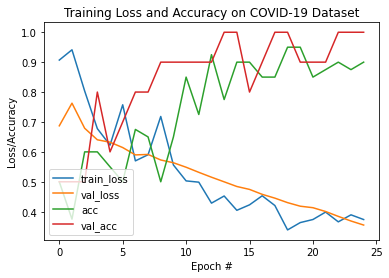

In [57]:
N=EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy ")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")